In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


#from keras.layers import Dense, Input
#from keras.models import Model

#import omnifold6b as of

#import tensorflow as tf

#import simple_pdf2b as simple_pdf


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
#print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4





## Set model and resolution parameters

In [3]:
ndim = 1

##-------------

train_mu = [ 0.0 ]



train_rho = [ [0.0] ]






train_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]






true_rho  = [ [0.0] ]



true_sig = [ 0.9 ]






#--- perfect
#resolution = [ 0.000001  ]

#--- very good
#resolution = [ 0.05  ]

#--- good
#resolution = [ 0.25  ]

#--- nominal
#resolution = [ 0.5  ]

#--- medium poor
resolution = [ 0.75  ]

#--- poor
#resolution = [ 1.0  ]







train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                






ngen_train = 100000
ngen_true =   10000

#ngen_train = 1000000
#ngen_true =   100000

of_niter = 5





do_bootstrap = False

n_boot_samples = 500



ds_input_dir = 'toy-study6b-1d-1a-10k'


output_dir = 'hist-pdf-toy-study-1d-1b'

#save_step2_model = True



hist_low = -10.
hist_high = 10.

hist_nbins = 1000


hist_binwidth = (hist_high - hist_low) / hist_nbins

window_dx = 0.3

window_nbins = int( window_dx / hist_binwidth )

print(' window_nbins : %d' % window_nbins)

hist_pars = {}
hist_pars['low']  = hist_low
hist_pars['high'] = hist_high
hist_pars['nbins'] = hist_nbins
hist_pars['binwidth'] = hist_binwidth
hist_pars['window_dx'] = window_dx
hist_pars['window_nbins'] = window_nbins






 Train covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100
 window_nbins : 15


In [4]:
hist_pars

{'low': -10.0,
 'high': 10.0,
 'nbins': 1000,
 'binwidth': 0.02,
 'window_dx': 0.3,
 'window_nbins': 15}

In [5]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [6]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.000000
True covariance determinant:   0.810000





In [7]:
train_cov_inv = np.linalg.inv( train_cov )

In [8]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [9]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[1.]]

 Train covariance inverse
[[1.]]

 Train covariance inverse test
[[1.]]





In [10]:
true_cov_inv = np.linalg.inv( true_cov )

In [11]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [12]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [13]:

#--- Read the datasets instead of generating new ones.

train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )



#with open('%s/train-and-true-samples.npy' % ds_input_dir, 'rb') as f :
#    train_pts = np.load(f)
#    train_det_pts = np.load(f)
#    true_pts = np.load(f)
#    true_det_pts = np.load(f)

print('\n\n train_pts:')
print( train_pts )
print('\n\n')
print(' train_pts shape:  %s' % str(train_pts.shape))

train_both = np.stack([train_pts, train_det_pts], axis=1)
    
#-- ok to regenerate these (just for plots)
true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights




 train_pts:
[[ 0.43655601]
 [ 0.23384962]
 [-1.62649153]
 ...
 [-0.31991842]
 [ 1.21649834]
 [ 1.15942507]]



 train_pts shape:  (100000, 1)


In [14]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [15]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [16]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )



config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : hist-pdf-toy-study-1d-1b/config.txt

2024-07-10 08:13:35.630032

ngen_train 100000
ngen_true  10000
of_niter   5
ndim       1


train_mu : [0.0]
train_rho : [[0.0]]
train_sig : [1.0]
train_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution : [0.75]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

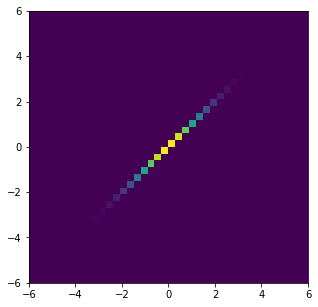

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

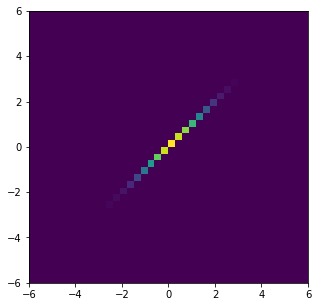

In [18]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

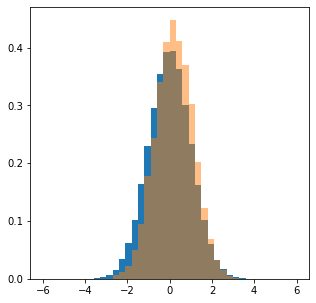

In [19]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [20]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[ 0.43655601]
 [ 0.23384962]
 [-1.62649153]
 ...
 [-0.31991842]
 [ 1.21649834]
 [ 1.15942507]]


In [21]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[ 0.23655601]
 [ 0.03384962]
 [-1.82649153]
 ...
 [-0.51991842]
 [ 1.01649834]
 [ 0.95942507]]


In [22]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [23]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [24]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [25]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [26]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [27]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [28]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [29]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 3.141593



In [30]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.51290968 0.54897204 0.15030296 ... 0.5360441  0.26920044 0.28808544]


In [31]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.60559317 0.62643409 0.07995369 ... 0.53053697 0.33126894 0.35515104]


In [32]:
pdf_ratio = pdf_true / pdf_train

In [33]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [34]:
calc_weight = pdf_ratio

In [35]:
calc_weight_scaled = sample_sf * pdf_ratio

In [36]:
with open( '%s/analytic-weights.npy' % output_dir, 'wb') as f :
    np.save(f, calc_weight_scaled)

## Define function for calculating model pars (mean and cov) from weighted events

In [37]:
def calc_mean_cov( weights, fi1, fi2, sample_points ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * sample_points[:,fi1] )
    wx2 = np.sum( weights * sample_points[:,fi2] )
    wx1x2 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi1] )
        wx2x2 = np.sum( weights * sample_points[:,fi2] * sample_points[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [38]:
weights_true = np.ones( ngen_true )

In [39]:
true_calc_mean = np.zeros( ndim )
true_calc_cov = np.ones( shape=(ndim,ndim) )

In [40]:
for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        rd = calc_mean_cov( weights_true, fi1, fi2, true_pts )
        true_calc_mean[fi1] = rd['mean_x1']
        true_calc_cov[fi1,fi2] = rd['cov_x1x2']

In [41]:
for fi1 in range(ndim) :
    print('  mean f%d :  %7.3f' % (fi1, true_calc_mean[fi1]))
    for fi2 in range(fi1,ndim) :
        print('  cov f%df%d :  %7.4f' % (fi1,fi2, true_calc_cov[fi1,fi2]))
        if fi1 == fi2 :
            print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(true_calc_cov[fi1,fi1])))
        

  mean f0 :    0.211
  cov f0f0 :   0.7969
  sigma f0 :   0.8927


In [42]:
print( true_pts.shape )
print( true_pts.shape[1])

(10000, 1)
1


In [43]:
def calc_model_pars( weights, sample_points, verbose=0 ) :
    
    return_dict = {}
    
    ndim = sample_points.shape[1]
    if verbose : print(' ndim = %d' % ndim )
    
    model_mean = np.zeros( ndim )
    model_cov = np.ones( shape=(ndim,ndim) )
    
    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            rd = calc_mean_cov( weights, fi1, fi2, sample_points )
            model_mean[fi1] = rd['mean_x1']
            model_cov[fi1,fi2] = rd['cov_x1x2']    
            if verbose and fi2==fi1 : print('  mean f%d :  %7.3f' % (fi1, model_mean[fi1]))
            if verbose : print('  cov f%df%d :  %7.4f' % (fi1,fi2, model_cov[fi1,fi2]))
            if verbose and fi2==fi1 : print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(model_cov[fi1,fi1])))
   
    for fi2 in range(ndim) :
        for fi1 in range(fi2+1,ndim) :
            model_cov[fi1,fi2] = model_cov[fi2,fi1]
    
    return_dict['mean'] = model_mean
    return_dict['cov']  = model_cov
    
    return return_dict


In [44]:
test_calc_true_model = calc_model_pars( weights_true, true_pts, 1)

 ndim = 1
  mean f0 :    0.211
  cov f0f0 :   0.7969
  sigma f0 :   0.8927


In [45]:
test_calc_true_model

{'mean': array([0.2108054]), 'cov': array([[0.79685434]])}

## Define function to calculate the reweighting factor (pdf2/pdf1).

In [46]:
def calc_pdf_ratio( model1_mu, model2_mu, model1_cov, model2_cov, sample_points ) :
    
    ndim = len(model1_mu)
    
    pts_minus_mu1 = sample_points - model1_mu
    pts_minus_mu2 = sample_points - model2_mu
    
    cov1_inv = np.linalg.inv( model1_cov )
    cov2_inv = np.linalg.inv( model2_cov )
    
    cov1_det = np.linalg.det( model1_cov )
    cov2_det = np.linalg.det( model2_cov )
    
    cov1_inv_times_v1 = np.tensordot( cov1_inv, pts_minus_mu1.T, axes=(1,0) )
    cov2_inv_times_v2 = np.tensordot( cov2_inv, pts_minus_mu2.T, axes=(1,0) )
    
    v1_times_cov1_inv_times_v1 =  np.sum( pts_minus_mu1.T * cov1_inv_times_v1, axis=0)
    v2_times_cov2_inv_times_v2 =  np.sum( pts_minus_mu2.T * cov2_inv_times_v2, axis=0)
    
    exp_v1_times_cov1_inv_times_v1 = np.exp( -0.5 * v1_times_cov1_inv_times_v1 )
    exp_v2_times_cov2_inv_times_v2 = np.exp( -0.5 * v2_times_cov2_inv_times_v2 )
    
    norm2_model1 = np.power( 3.14159265, ndim) * cov1_det
    norm2_model2 = np.power( 3.14159265, ndim) * cov2_det
    
    pdf1 = exp_v1_times_cov1_inv_times_v1 / np.sqrt(norm2_model1)
    pdf2 = exp_v2_times_cov2_inv_times_v2 / np.sqrt(norm2_model2)
    
    pdf_ratio = pdf1 / pdf2
    
    return pdf_ratio
    
    

In [47]:
test_calc_pdf_ratio = calc_pdf_ratio( true_mu, train_mu, true_cov, train_cov, train_pts )

In [48]:
test_calc_pdf_ratio

array([1.18070138, 1.14110382, 0.5319502 , ..., 0.98972634, 1.23056613,
       1.23279761])

In [49]:
pdf_ratio

array([1.18070138, 1.14110382, 0.5319502 , ..., 0.98972634, 1.23056613,
       1.23279761])

## Function that estimates the pdf from a histogram (multi-bin sum)

In [50]:

#-- computes pdf2/pdf1 at location of points1
#
#    for OmniFold step 1, points2 is the data, points1 is the MC
#

def pdf_ratio_from_hist( points1, points2, weights1, weights2, hist_pars, verbose=0 ) :
    
    ndim = points1.shape[1]
    
    if ndim > 1 :
        print('\n\n *** Only 1D supported for now.\n\n')
        sys.exit()
        
    hist_low = hist_pars['low']
    hist_high = hist_pars['high']
    hist_nbins = hist_pars['nbins']
    hist_binwidth = hist_pars['binwidth']
    
    
    nph1 = np.histogram( points1[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights1 )
    nph2 = np.histogram( points2[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights2 )
    
    hist_pdf1 = np.zeros(hist_nbins)
    hist_pdf2 = np.zeros(hist_nbins)

    for bi in range( hist_nbins ) :
        bilow = bi - window_nbins
        bihigh = bi + window_nbins
        if bilow < 0 : bilow = 0
        if bihigh >= hist_nbins : bihigh = hist_nbins-1

        hist_pdf1[bi] = np.sum( nph1[0][bilow: bihigh] )
        hist_pdf2[bi] = np.sum( nph2[0][bilow: bihigh] )
    
    hist_pdf1_norm = hist_pdf1 / np.sum(hist_pdf1)
    hist_pdf2_norm = hist_pdf2 / np.sum(hist_pdf2)
    
    hist_bin_indices1 = np.array(   ( (points1[:,0] - hist_low) / hist_binwidth ),   dtype=int )
    
    points1_pdf1_val = hist_pdf1_norm[ hist_bin_indices1 ]
    points1_pdf2_val = hist_pdf2_norm[ hist_bin_indices1 ]
    
    points1_pdf1_val = np.clip( points1_pdf1_val, 1.e-10, 1.e10)
    points1_pdf2_val = np.clip( points1_pdf2_val, 1.e-10, 1.e10)
    
    pdf_ratio = points1_pdf2_val / points1_pdf1_val
    
    return pdf_ratio
    

In [51]:
print('pdf_ratio shape : %s' % str(pdf_ratio.shape))

pdf_ratio shape : (100000,)


In [52]:
weights_true = np.ones( ngen_true )
weights_train = np.ones( ngen_train )

print(' train_pts shape: %s' % str(train_pts.shape))
print('  true_pts shape: %s' % str(true_pts.shape))
print(' weights_train shape: %s' % str(weights_train.shape))
print('  weights_true shape: %s' % str(weights_true.shape))

test_hist_pdf_ratio = pdf_ratio_from_hist( train_pts, true_pts, weights_train, weights_true, hist_pars )

 train_pts shape: (100000, 1)
  true_pts shape: (10000, 1)
 weights_train shape: (100000,)
  weights_true shape: (10000,)


In [53]:
pdf_ratio

array([1.18070138, 1.14110382, 0.5319502 , ..., 0.98972634, 1.23056613,
       1.23279761])

In [54]:
calc_weight

array([1.18070138, 1.14110382, 0.5319502 , ..., 0.98972634, 1.23056613,
       1.23279761])

In [55]:
test_hist_pdf_ratio

array([1.13563513, 1.13097551, 0.50290743, ..., 1.00215711, 1.27582427,
       1.28478811])

In [56]:
test_hist_pdf_ratio.shape

(100000,)

In [57]:
for pi in range(40) :
    print( ' %3d   x %7.3f   true  %7.4f  from hist %7.4f' % (pi, train_pts[pi,0], calc_weight[pi], test_hist_pdf_ratio[pi]))

   0   x   0.437   true   1.1807  from hist  1.1356
   1   x   0.234   true   1.1411  from hist  1.1310
   2   x  -1.626   true   0.5320  from hist  0.5029
   3   x  -2.195   true   0.3582  from hist  0.3488
   4   x  -1.558   true   0.5552  from hist  0.5339
   5   x  -0.036   true   1.0741  from hist  1.0879
   6   x  -1.283   true   0.6510  from hist  0.6242
   7   x   0.394   true   1.1732  from hist  1.1456
   8   x  -0.724   true   0.8524  from hist  0.8449
   9   x  -0.571   true   0.9062  from hist  0.9101
  10   x   0.258   true   1.1464  from hist  1.1248
  11   x   1.367   true   1.2203  from hist  1.2578
  12   x  -1.711   true   0.5039  from hist  0.4887
  13   x  -1.714   true   0.5030  from hist  0.4887
  14   x   0.129   true   1.1169  from hist  1.1096
  15   x   0.940   true   1.2326  from hist  1.2623
  16   x  -1.579   true   0.5479  from hist  0.5302
  17   x  -0.376   true   0.9717  from hist  0.9589
  18   x   0.282   true   1.1515  from hist  1.1297
  19   x  -0

## Define OmniFold implementation with fit pdf

In [58]:
def hist_pdf_omnifold1a( theta0, theta_unknown_S, iterations, verbose=0 ) :
    
    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)
    push_weights_for_output = np.empty(shape=(iterations, len(theta0)))

    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    ngen_train = len(theta0)
    ngen_true  = len(theta_unknown_S)
    ndim = theta0_G.shape[1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))
    labels_unknown_step2 = np.ones(len(theta0_G))


    neval_train = ngen_train
    neval_true  = ngen_true


    if verbose :
        print("\n\n")
        print("  ======== simple_pdf2b\n\n")
        print("  shape of theta0_S : %s" % str(np.shape(theta0_S)) )
        print("  shape of theta0_G : %s" % str(np.shape(theta0_G)) )
        print("  shape of theta_unknown_S : %s" % str(np.shape(theta_unknown_S)) )
        print("\n  iterations = %d\n" % iterations )
        print("  ndim : %d" % ndim )
        print("  neval_train : %d" % neval_train )
        print("  neval_true  : %d" % neval_true )
        print("\n\n")

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))


    sample_norm_sf = ( (1.*neval_train)/(1.*neval_true) ) *  ( (1.*ngen_true)/(1.*ngen_train) )
    
    
    if verbose :
        print('\n\n Calculating model pars for data or true (theta_unknown_S)')
        
    
    #model_pars_theta_unknown_S = calc_model_pars( np.ones( ngen_true ), theta_unknown_S, verbose )
    
    
    
    
    
    
    return_dict = {}
    
    for i in range(iterations):
    
        if (verbose>0):
            print("\nITERATION: {}\n".format(i + 1))
            
        if (verbose>0):
            print("   -- ITERATION %d  STEP 1\n" % (i+1) )
            
        print(" weights_push at the beginning")
        print( weights_push )

        
        #model_pars_theta0_S = calc_model_pars( weights_push, theta0_S, verbose )
        
        #pdf_ratio_step1 = calc_pdf_ratio( model_pars_theta_unknown_S['mean'],
        #                           model_pars_theta0_S['mean'],
        #                           model_pars_theta_unknown_S['cov'],
        #                           model_pars_theta0_S['cov'],
        #                           theta0_S )

        pdf_ratio_step1 = pdf_ratio_from_hist( theta0_S, 
                                              theta_unknown_S, 
                                              weights_push, 
                                              np.ones( ngen_true ),
                                              hist_pars
                                             )
        if verbose>0 :
            print(' pdf_ratio_step1:  shape %s ' % str(pdf_ratio_step1.shape))
            print(pdf_ratio_step1)
        
        
        step1_output_weights = sample_norm_sf * pdf_ratio_step1

        weights_pull = weights_push * step1_output_weights
        
        if verbose>0 :
            print("  iter %d, step1_output_weights:  shape %s" % (i+1, str(step1_output_weights.shape)))
            print(step1_output_weights)


        weights[i, :1, :] = step1_output_weights


            
            

        if (verbose>0):
            print("\n   -- ITERATION %d  STEP 2\n" % (i+1) )
            
        #if verbose : print(' calculation of model pars with push weights')
        #model_pars_theta0_G_push_weight = calc_model_pars( weights_push, theta0_G, verbose )

        #if verbose : print(' calculation of model pars with pull weights')
        #model_pars_theta0_G_pull_weight = calc_model_pars( weights_pull, theta0_G, verbose )
        
        #pdf_ratio_step2 = calc_pdf_ratio( model_pars_theta0_G_pull_weight['mean'],
        #                           model_pars_theta0_G_push_weight['mean'],
        #                           model_pars_theta0_G_pull_weight['cov'],
        #                           model_pars_theta0_G_push_weight['cov'],
        #                           theta0_G )        

        
        pdf_ratio_step2 = pdf_ratio_from_hist( theta0_G, 
                                              theta0_G, 
                                              weights_push, 
                                              weights_pull,
                                              hist_pars
                                             )
        
        
        step2_output_weights = pdf_ratio_step2
        
        weights_push = weights_push * step2_output_weights
        
        push_weights_for_output[i] = weights_push
        
        weights[i, 1:2, :] = step2_output_weights
        
        if verbose>0 :
           print("  iter %d, step2_output_weights:" % (i+1))
           print(step2_output_weights)
        
    return_dict["weights"] = weights

    return_dict["push_weights"] = push_weights_for_output

    return_dict["final_push_weights"] = weights_push

    return return_dict
            
            

In [59]:
rd = hist_pdf_omnifold1a( train_both, true_det_pts, of_niter, 1 )




  ======== simple_pdf2b


  shape of theta0_S : (100000, 1)
  shape of theta0_G : (100000, 1)
  shape of theta_unknown_S : (10000, 1)

  iterations = 5

  ndim : 1
  neval_train : 100000
  neval_true  : 10000





 Calculating model pars for data or true (theta_unknown_S)

ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 pdf_ratio_step1:  shape (100000,) 
[1.00848053 1.06222667 0.77401951 ... 0.75197157 1.09090909 1.18736067]
  iter 1, step1_output_weights:  shape (100000,)
[1.00848053 1.06222667 0.77401951 ... 0.75197157 1.09090909 1.18736067]

   -- ITERATION 1  STEP 2

  iter 1, step2_output_weights:
[1.08639308 1.06173077 0.72367386 ... 0.98682869 1.15203008 1.14914003]

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[1.08639308 1.06173077 0.72367386 ... 0.98682869 1.15203008 1.14914003]
 pdf_ratio_step1:  shape (100000,) 
[1.01443394 1.02731266 0.8903871  ... 0.87435982 0.96032485 1.06662408]
  iter 2, ste

In [60]:
of_weights = rd["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = rd["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = rd["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


<function matplotlib.pyplot.show(close=None, block=None)>

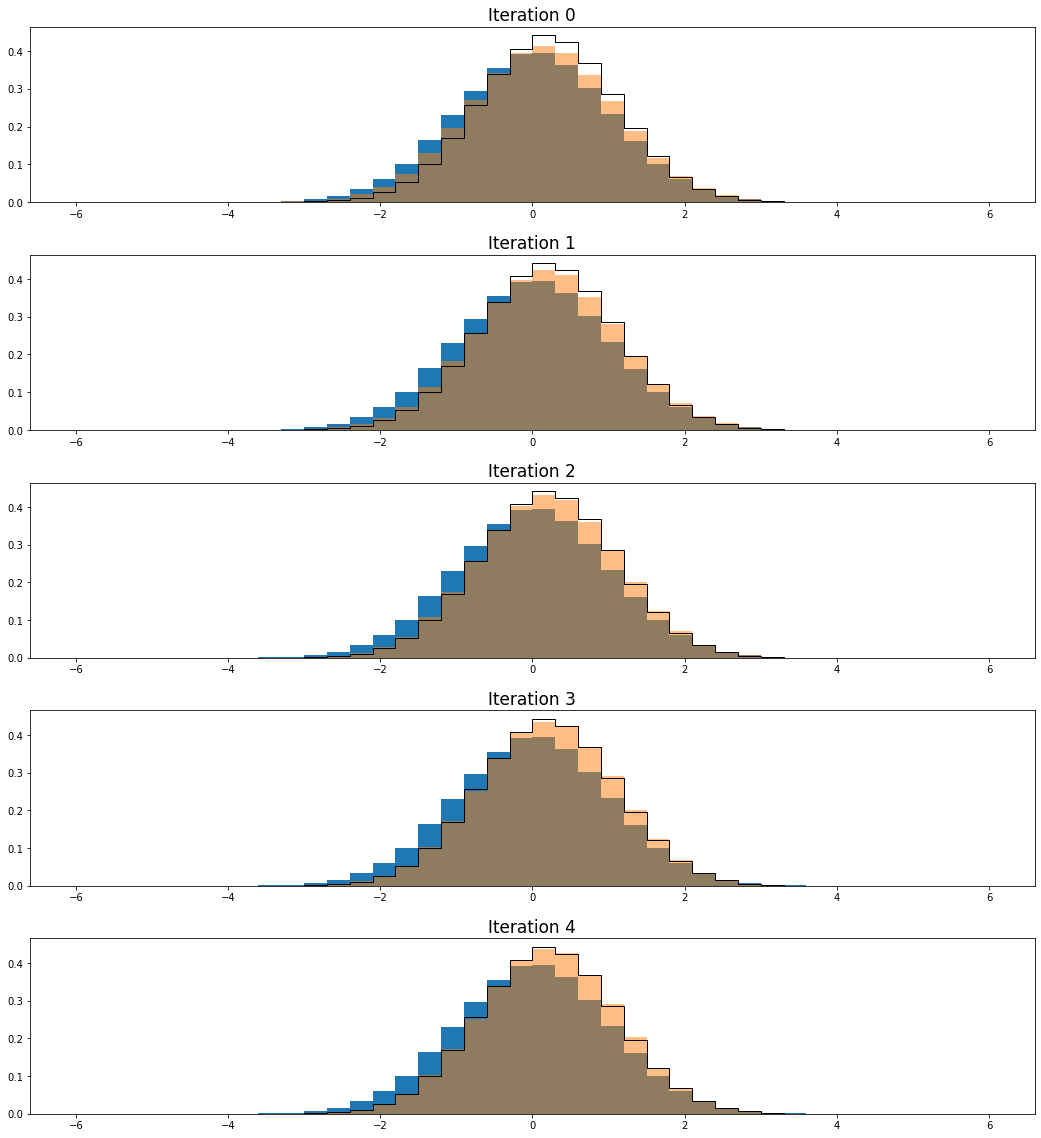

In [61]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [62]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

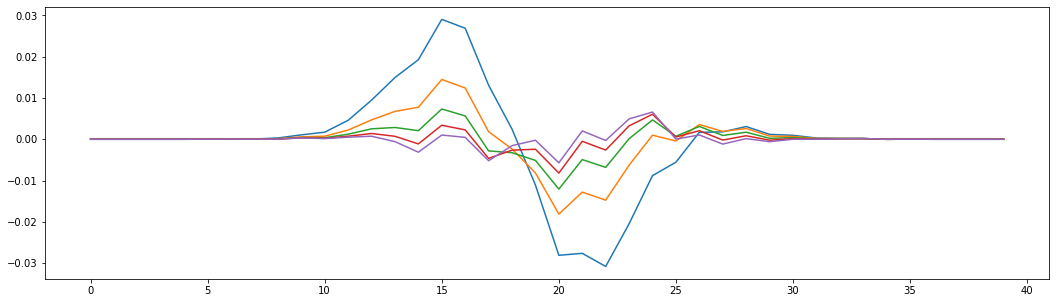

In [63]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

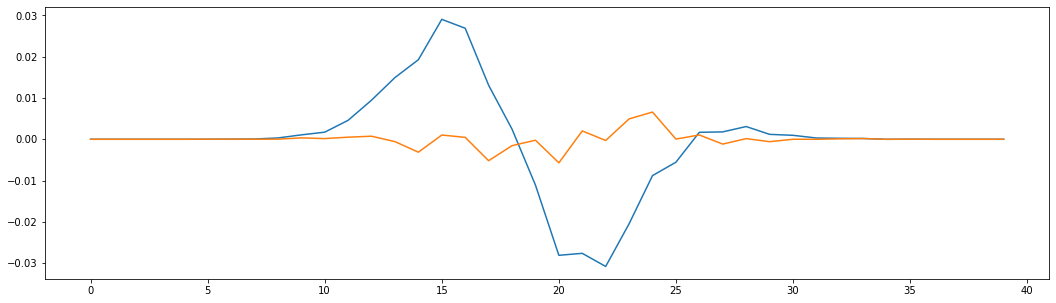

In [64]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

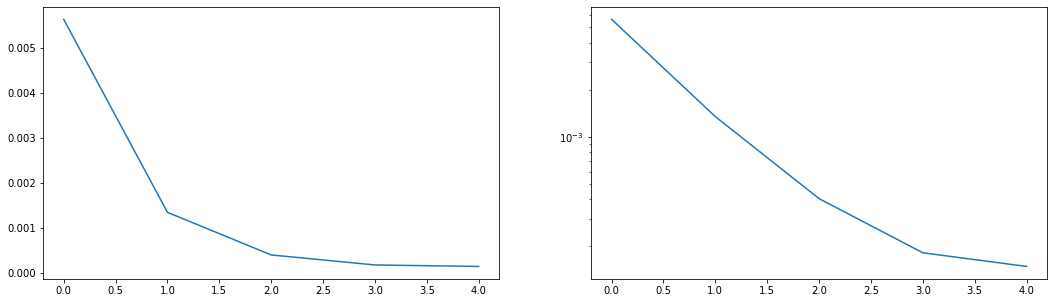

In [65]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

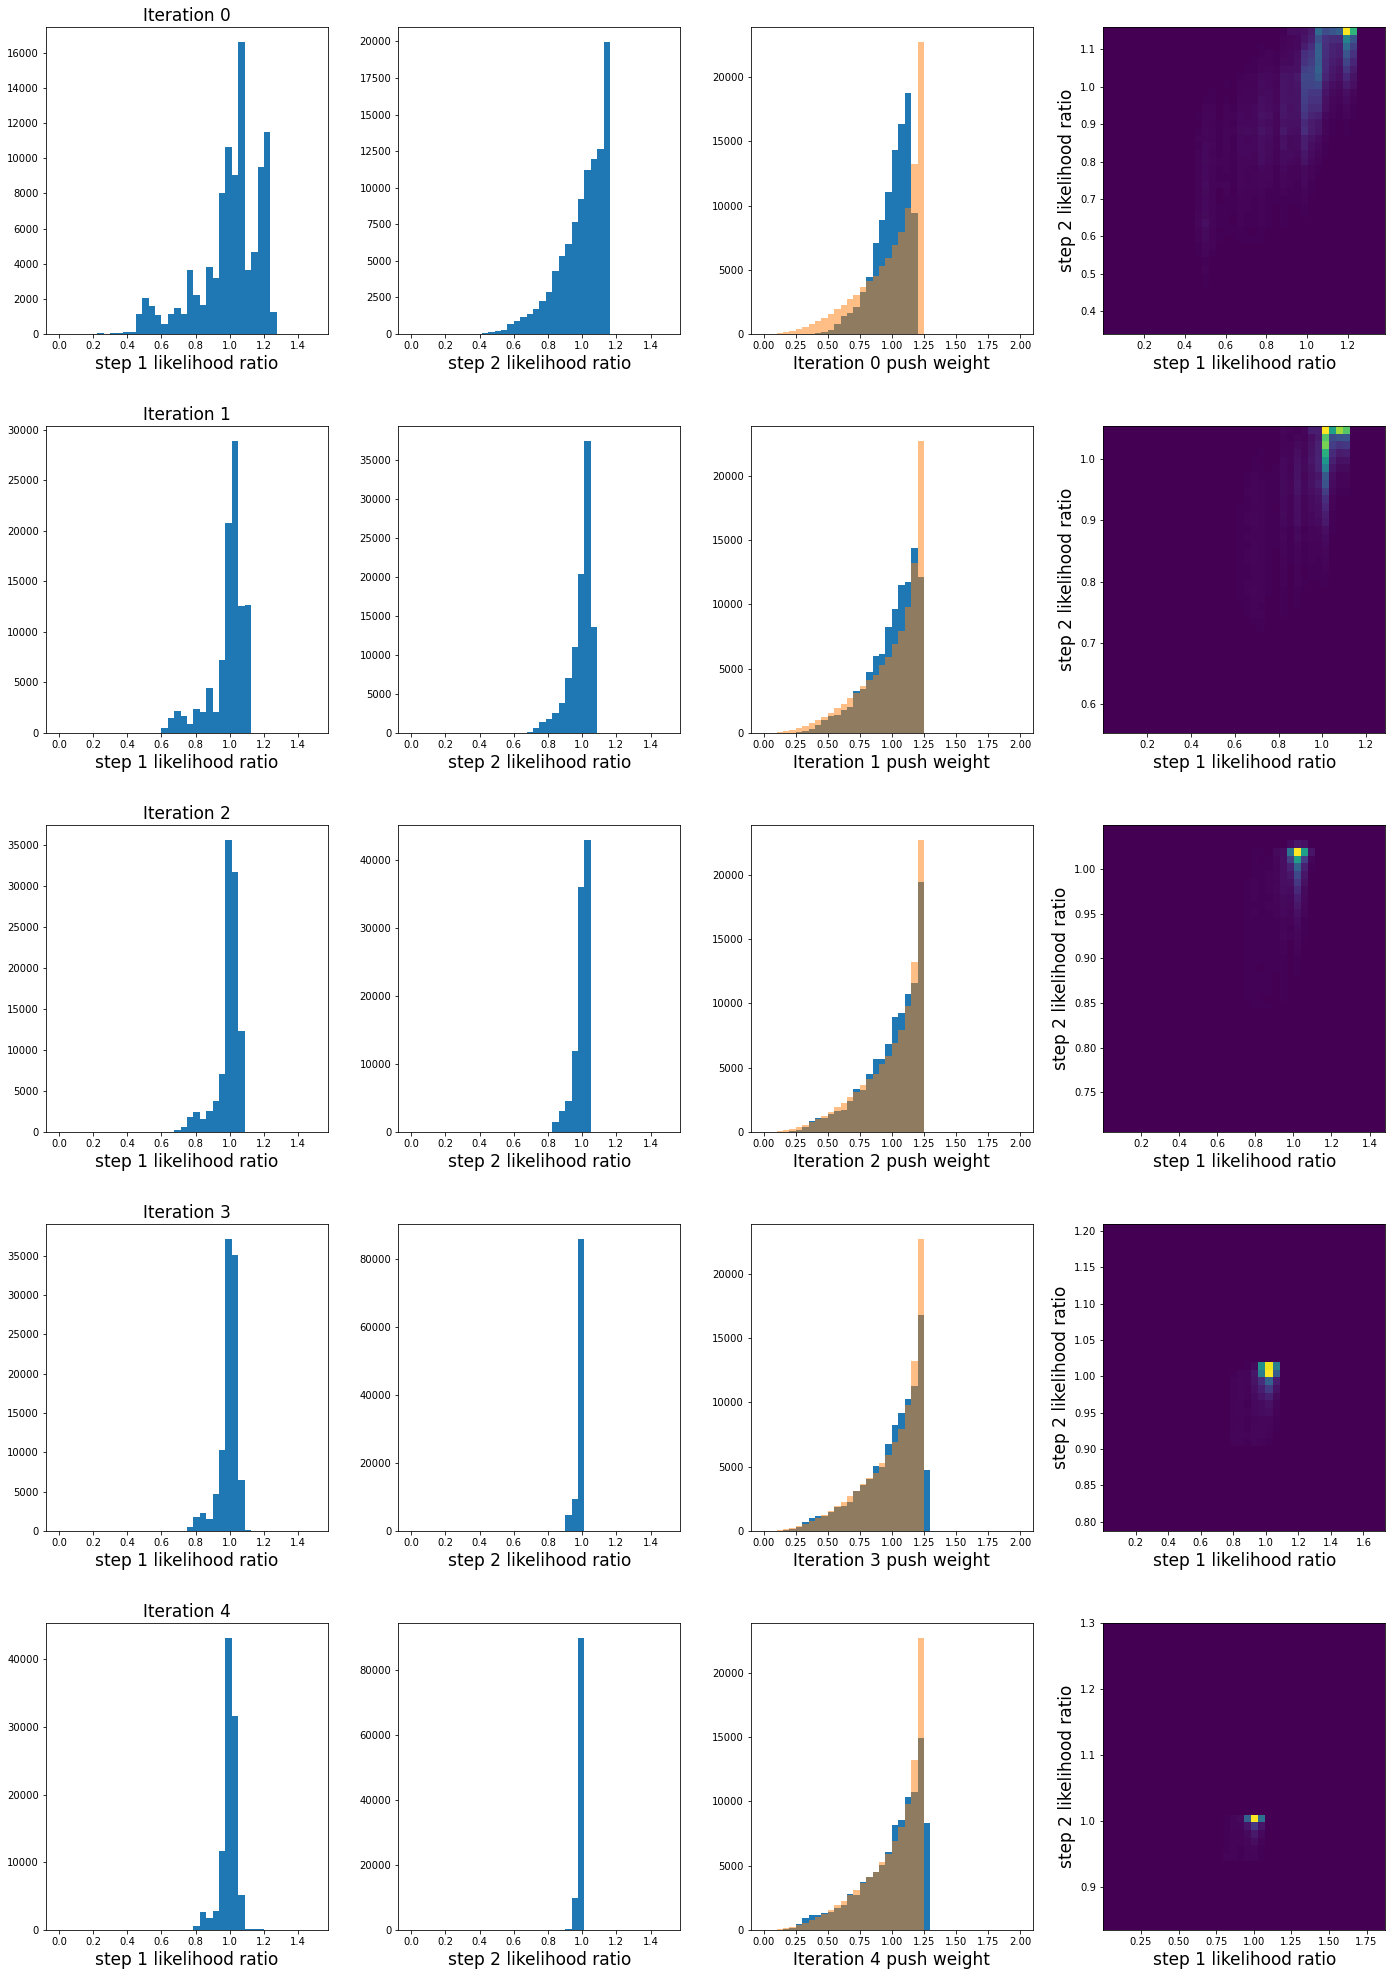

In [66]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

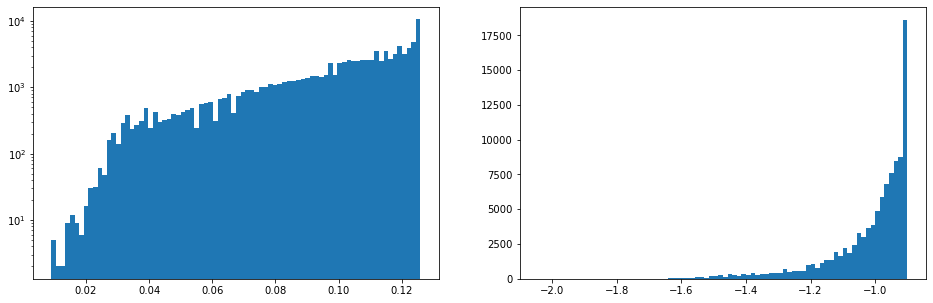

In [67]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

final_push_weights_scaled = np.clip( final_push_weights_scaled, 1e-11, 1e11)

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

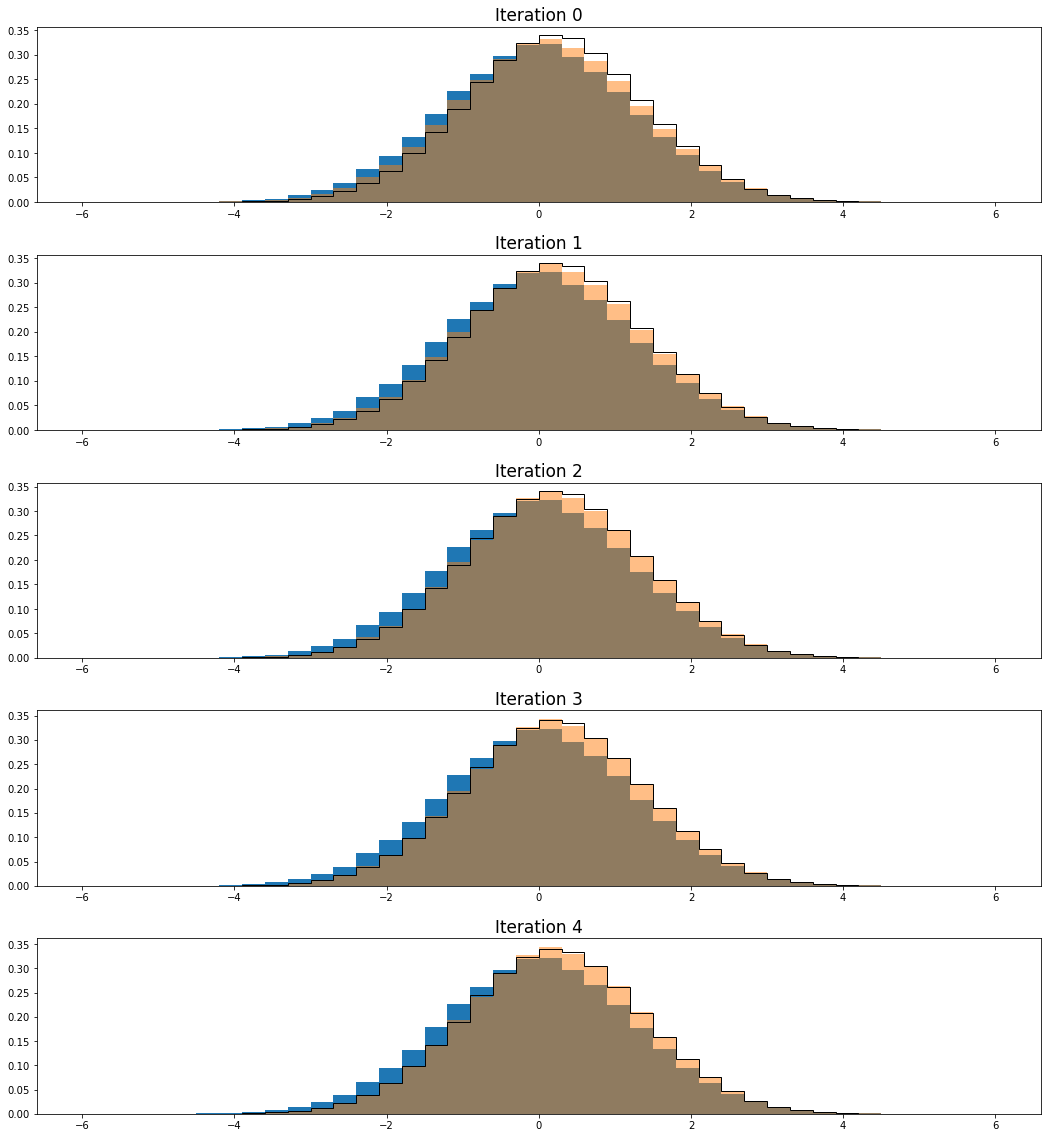

In [68]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [69]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

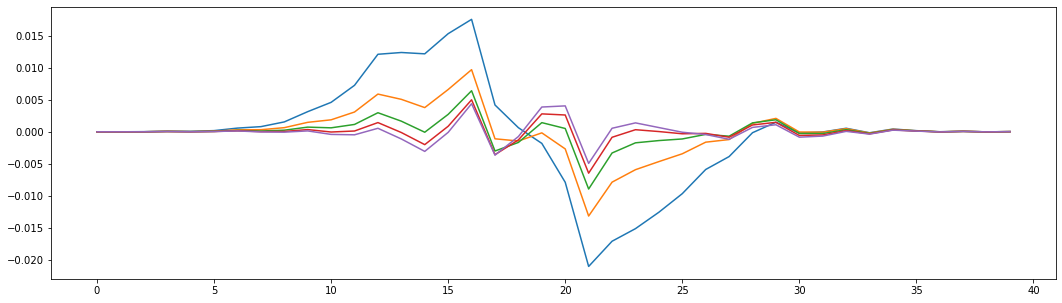

In [70]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

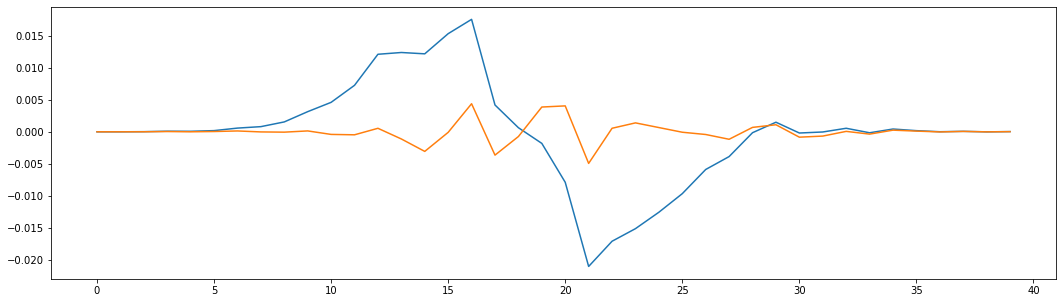

In [71]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

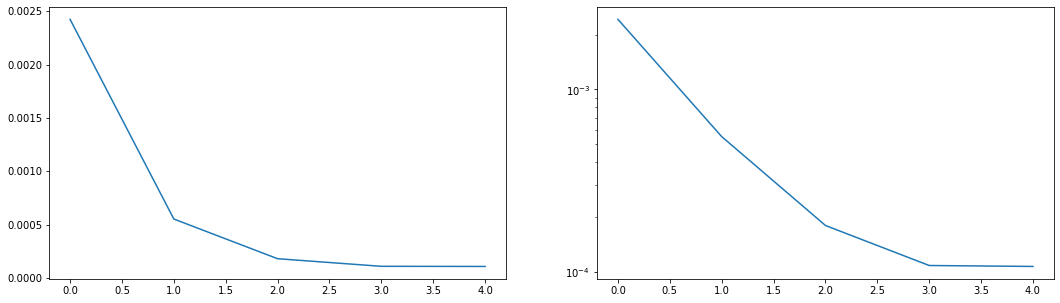

In [72]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [73]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.000  rms 0.187      step 2 mean  1.000  rms 0.138
  iter  1 : step 1 mean  0.991  rms 0.104      step 2 mean  0.991  rms 0.069
  iter  2 : step 1 mean  0.993  rms 0.070      step 2 mean  0.994  rms 0.038
  iter  3 : step 1 mean  0.996  rms 0.055      step 2 mean  0.996  rms 0.023
  iter  4 : step 1 mean  0.998  rms 0.049      step 2 mean  0.997  rms 0.015


<function matplotlib.pyplot.show(close=None, block=None)>

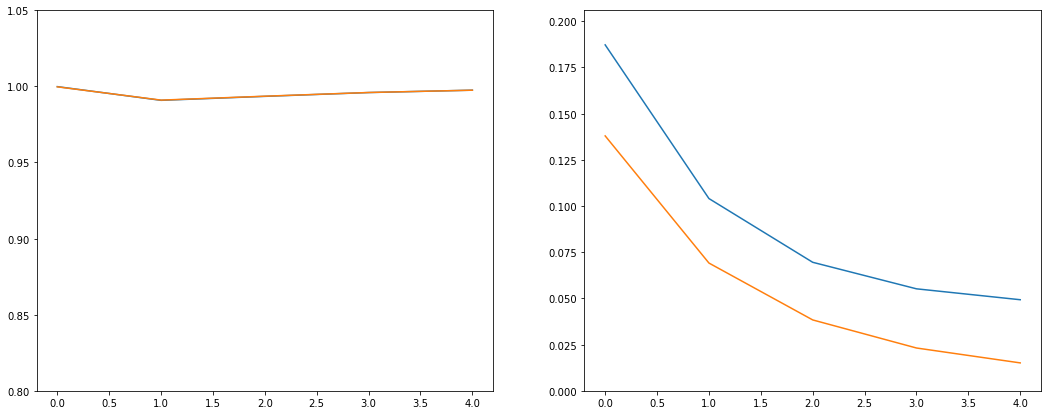

In [74]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

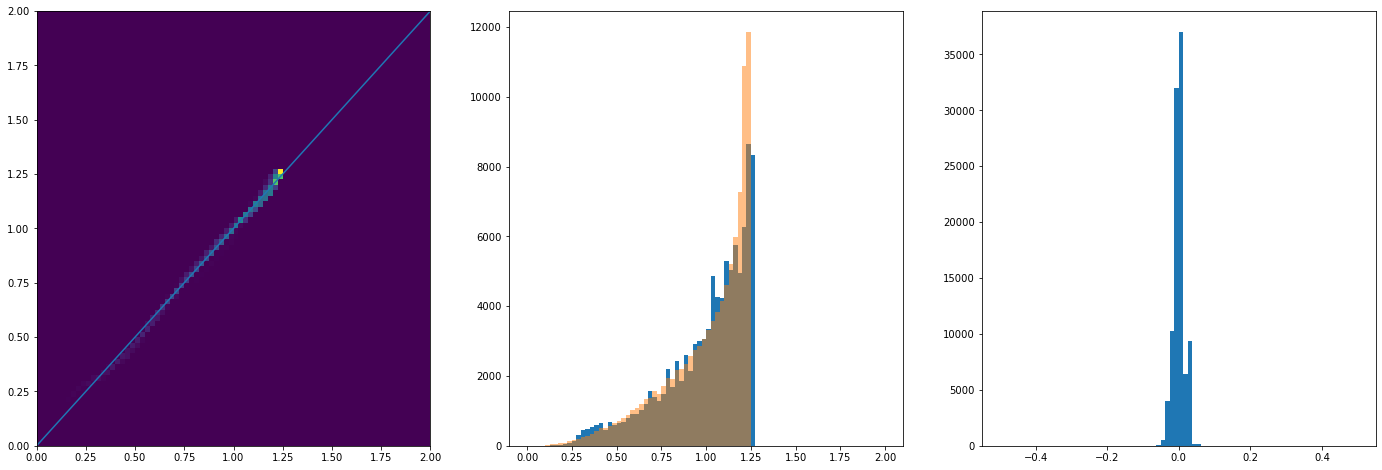

In [75]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [76]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.01578




In [77]:

verbose = False



import gc

In [78]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        #print("\n Creating bootstrap sample %3d" % bi )
        #boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        fname = "%s/bootstrap-points-%03d.npy" % (ds_input_dir, bi)
        print('\n Reading bootstrap sample from file: %s' % fname )
        with open( fname, 'rb' ) as f :
            boot_true_det_pts = np.load(f)
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        

        
#    boot_of_return_dict = of.omnifold6b( 
#        train_both, boot_true_det_pts, of_niter, model, verbose, 
#        batch_size_setval, learning_rate_setval, epochs_setval )

#    rd = simple_pdf.simple_pdf2b( train_both, boot_true_det_pts, 
#                             train_train_det_within_sphere, train_train_gen_within_sphere,
#                             of_niter, radius, norm_radius2, False, False )

#    rd = fit_pdf_omnifold1a( train_both, boot_true_det_pts, of_niter, 0 )
    
    rd = hist_pdf_omnifold1a( train_both, boot_true_det_pts, of_niter, 0 )
    
    
    
    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = rd["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )
        
    del boot_final_push_weights_scaled
    del rd
    gc.collect()
    
    


 Creating toy sample   0
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08610572 1.06224105 0.7282391  ... 0.98676445 1.14760024 1.14476988]
 weights_push at the beginning
[1.12688105 1.093013   0.61739385 ... 0.98376477 1.20527249 1.20254088]
 weights_push at the beginning
[1.14938554 1.11159077 0.56368675 ... 0.98658667 1.22735773 1.2256528 ]
 weights_push at the beginning
[1.16273423 1.12356417 0.53431946 ... 0.99101735 1.23534074 1.23473717]


 bootstrap 0 final push weights scaled:
[0.11709135 0.11314048 0.05167983 ... 0.09952671 0.12378497 0.12381573]

 Creating toy sample   1
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.06938906 1.04488614 0.7750268  ... 0.97411552 1.14222709 1.13787465]
 weights_push at the beginning
[1.10054949 1.06518189 0.68833329 ... 0.96319208 1.1993528  1.19390843]
 weights_push at the beginning
[1.11721758 1.07686438 0.65072739 ... 0.96000187 1.22225937 1.21701713]
 we


 Creating toy sample  14
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07648429 1.05613896 0.7809855  ... 0.98855259 1.118224   1.11719094]
 weights_push at the beginning
[1.11613939 1.08658809 0.69124167 ... 0.98550196 1.16461251 1.16478171]
 weights_push at the beginning
[1.13991538 1.10610628 0.64903742 ... 0.98661996 1.18226291 1.18421225]
 weights_push at the beginning
[1.15550885 1.11960884 0.62710713 ... 0.98886254 1.18841681 1.19208206]


 bootstrap 14 final push weights scaled:
[0.11664015 0.1129381  0.0614772  ... 0.09910368 0.11900322 0.11951699]

 Creating toy sample  15
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08077711 1.05882073 0.76217895 ... 0.98660349 1.13171877 1.12962038]
 weights_push at the beginning
[1.12117871 1.08964312 0.66713751 ... 0.98266257 1.18298178 1.18139964]
 weights_push at the beginning
[1.1447706  1.10912234 0.62376309 ... 0.98374051 1.20213852 1.20185488]
 w

 weights_push at the beginning
[1.14479778 1.10757528 0.58789946 ... 0.98274402 1.21713376 1.21528225]
 weights_push at the beginning
[1.15846853 1.11973034 0.56071131 ... 0.98619013 1.22410554 1.22328256]


 bootstrap 28 final push weights scaled:
[0.11672308 0.11280345 0.05445613 ... 0.09896613 0.12256484 0.12256829]

 Creating toy sample  29
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07933752 1.05608502 0.74642344 ... 0.98309044 1.14382233 1.14036165]
 weights_push at the beginning
[1.11665005 1.08376672 0.64452291 ... 0.97805744 1.2008493  1.1968955 ]
 weights_push at the beginning
[1.13715345 1.10060602 0.5965412  ... 0.97943428 1.22317452 1.21975216]
 weights_push at the beginning
[1.14935829 1.11167743 0.57118987 ... 0.98285573 1.23163622 1.22890626]


 bootstrap 29 final push weights scaled:
[0.11569375 0.11191869 0.05565319 ... 0.09864803 0.12346352 0.12324705]

 Creating toy sample  30
 weights_push at the beginning
[1. 1. 1. ... 


 Creating toy sample  42
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07818658 1.04914204 0.74022035 ... 0.97131842 1.17061832 1.16542621]
 weights_push at the beginning
[1.11091926 1.06852429 0.6389612  ... 0.95861541 1.24475193 1.2377919 ]
 weights_push at the beginning
[1.12663255 1.07780901 0.59291158 ... 0.9548321  1.27933129 1.2720211 ]
 weights_push at the beginning
[1.13440426 1.08211048 0.56955312 ... 0.9543482  1.29756481 1.29031478]


 bootstrap 42 final push weights scaled:
[0.11379757 0.10834805 0.05566784 ... 0.09547011 0.13089659 0.13018065]

 Creating toy sample  43
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08268761 1.05926297 0.74232986 ... 0.98590915 1.14265271 1.13996544]
 weights_push at the beginning
[1.12224808 1.0887493  0.63746461 ... 0.98216435 1.1994331  1.1968557 ]
 weights_push at the beginning
[1.14422189 1.10652666 0.58727752 ... 0.98408697 1.22194403 1.22036498]
 w


 Creating toy sample  56
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08257144 1.05958528 0.73440482 ... 0.98523084 1.14312489 1.13992036]
 weights_push at the beginning
[1.12170618 1.08954848 0.62700346 ... 0.98188438 1.19661504 1.1933312 ]
 weights_push at the beginning
[1.14361109 1.10825532 0.57560066 ... 0.98478757 1.21489159 1.21257737]
 weights_push at the beginning
[1.15698394 1.12089385 0.54785968 ... 0.98949351 1.2194138  1.21821391]


 bootstrap 56 final push weights scaled:
[0.1165575  0.11297226 0.05315067 ... 0.09941283 0.12187318 0.12184992]

 Creating toy sample  57
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07748331 1.0549585  0.74442404 ... 0.98287179 1.14217008 1.13836654]
 weights_push at the beginning
[1.11335621 1.08209668 0.6416333  ... 0.97837413 1.19564995 1.19127076]
 weights_push at the beginning
[1.13297923 1.09890415 0.59291526 ... 0.98060792 1.21414096 1.21034825]
 w


 Creating toy sample  70
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08168176 1.05777046 0.74835776 ... 0.98403655 1.13904687 1.13667432]
 weights_push at the beginning
[1.12107016 1.08645693 0.64681767 ... 0.97890743 1.19273197 1.19088924]
 weights_push at the beginning
[1.14342411 1.1038535  0.59901033 ... 0.97956747 1.2127307  1.21234084]
 weights_push at the beginning
[1.15731004 1.11517746 0.57402417 ... 0.98185464 1.21947094 1.22062247]


 bootstrap 70 final push weights scaled:
[0.11664568 0.11227333 0.05600133 ... 0.09840449 0.12211254 0.12236461]

 Creating toy sample  71
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07648518 1.0509693  0.75333106 ... 0.97633684 1.14770953 1.14406393]
 weights_push at the beginning
[1.11161258 1.07455785 0.6545599  ... 0.96671828 1.2075829  1.20347837]
 weights_push at the beginning
[1.13061984 1.08814548 0.60810509 ... 0.96456372 1.23207851 1.22869885]
 w


 Creating toy sample  84
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07892519 1.05379706 0.74382432 ... 0.98025422 1.15170057 1.14785242]
 weights_push at the beginning
[1.11462973 1.07865186 0.64214874 ... 0.97347354 1.21328722 1.20873143]
 weights_push at the beginning
[1.13349611 1.09288654 0.59505909 ... 0.97376526 1.23876804 1.23465534]
 weights_push at the beginning
[1.14420992 1.10157798 0.57081215 ... 0.97637157 1.24976759 1.24633441]


 bootstrap 84 final push weights scaled:
[0.11504578 0.11068808 0.05573626 ... 0.09792652 0.12550229 0.12521885]

 Creating toy sample  85
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08164721 1.05770637 0.74625511 ... 0.98172163 1.14231585 1.13957831]
 weights_push at the beginning
[1.12089845 1.0866245  0.64506587 ... 0.97539535 1.19663391 1.1942884 ]
 weights_push at the beginning
[1.14329172 1.10462755 0.59805842 ... 0.97554439 1.21606361 1.21516885]
 w


 Creating toy sample  98
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.0810186  1.05692314 0.7462706  ... 0.98316885 1.14559798 1.14253851]
 weights_push at the beginning
[1.11920982 1.08464513 0.64438332 ... 0.97772266 1.20441384 1.20118776]
 weights_push at the beginning
[1.14013575 1.10112327 0.59664311 ... 0.97851303 1.22828996 1.22587581]
 weights_push at the beginning
[1.15250581 1.11162605 0.57175457 ... 0.98128113 1.23803972 1.2365758 ]


 bootstrap 98 final push weights scaled:
[0.1160105  0.11184591 0.05577456 ... 0.09842208 0.12421019 0.12414515]

 Creating toy sample  99
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.0778945  1.05557705 0.73847009 ... 0.98771815 1.1426232  1.13898967]
 weights_push at the beginning
[1.11290616 1.08190614 0.63076316 ... 0.986298   1.19785827 1.19352946]
 weights_push at the beginning
[1.13097922 1.0971071  0.57794436 ... 0.99069066 1.21872049 1.21470324]
 w


 Creating toy sample 112
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08064756 1.05850264 0.75280125 ... 0.98643884 1.13238044 1.13024698]
 weights_push at the beginning
[1.12034423 1.08872649 0.65228468 ... 0.98293981 1.18242656 1.1809296 ]
 weights_push at the beginning
[1.14327144 1.107681   0.60457742 ... 0.98469549 1.20013224 1.20011024]
 weights_push at the beginning
[1.15776636 1.12049564 0.57935274 ... 0.98783769 1.20522092 1.20671662]


 bootstrap 112 final push weights scaled:
[0.11674946 0.11294726 0.05649348 ... 0.09907916 0.12055536 0.1208369 ]

 Creating toy sample 113
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08090664 1.05907582 0.75492094 ... 0.98748124 1.13150428 1.12948035]
 weights_push at the beginning
[1.12094712 1.08976675 0.65507032 ... 0.98442406 1.18186661 1.18045649]
 weights_push at the beginning
[1.1440428  1.10897863 0.60772034 ... 0.9863352  1.20010956 1.20008994]
 


 Creating toy sample 126
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07890955 1.05263766 0.73910785 ... 0.97683385 1.16000622 1.15539503]
 weights_push at the beginning
[1.11363578 1.07611736 0.6370115  ... 0.96814523 1.22571355 1.21987705]
 weights_push at the beginning
[1.13155529 1.08934622 0.59043688 ... 0.96748522 1.25335871 1.24762507]
 weights_push at the beginning
[1.14147523 1.09733516 0.56685419 ... 0.96963497 1.26559712 1.26030422]


 bootstrap 126 final push weights scaled:
[0.11470662 0.11021433 0.05540156 ... 0.09723324 0.12716118 0.12667384]

 Creating toy sample 127
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07230639 1.05154693 0.75240733 ... 0.98797954 1.13239314 1.12911154]
 weights_push at the beginning
[1.10457396 1.07593111 0.64916699 ... 0.98674347 1.18216032 1.17849112]
 weights_push at the beginning
[1.12110493 1.08993682 0.59789332 ... 0.99090434 1.19993097 1.19685495]
 


 Creating toy sample 140
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08191329 1.05865119 0.73837205 ... 0.98494029 1.14373516 1.14061415]
 weights_push at the beginning
[1.12062435 1.08775077 0.63216335 ... 0.98106224 1.19921719 1.19599324]
 weights_push at the beginning
[1.14207515 1.10551973 0.58115304 ... 0.98328747 1.21981052 1.21748963]
 weights_push at the beginning
[1.15496744 1.11719734 0.5534786  ... 0.98728814 1.22665308 1.22536685]


 bootstrap 140 final push weights scaled:
[0.11630695 0.11250776 0.05370108 ... 0.09912436 0.12282067 0.12278049]

 Creating toy sample 141
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08739491 1.0646042  0.71718291 ... 0.99030744 1.14378443 1.14110108]
 weights_push at the beginning
[1.12962576 1.09787548 0.59971187 ... 0.99053595 1.19792273 1.19544576]
 weights_push at the beginning
[1.15341775 1.11876772 0.54069821 ... 0.99636776 1.21676248 1.21536204]
 


 Creating toy sample 154
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07792336 1.05721033 0.73123525 ... 0.98958993 1.14032111 1.13634402]
 weights_push at the beginning
[1.11311994 1.08539175 0.61999408 ... 0.99011872 1.19190888 1.18704159]
 weights_push at the beginning
[1.13154341 1.10256631 0.56471189 ... 0.99648191 1.20904029 1.20434888]
 weights_push at the beginning
[1.14174486 1.11379292 0.53321934 ... 1.00431485 1.21295817 1.20861624]


 bootstrap 154 final push weights scaled:
[0.11473953 0.11212811 0.05133001 ... 0.10117996 0.12120475 0.12079371]

 Creating toy sample 155
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08301273 1.05722709 0.74538529 ... 0.97700842 1.14818048 1.14524652]
 weights_push at the beginning
[1.12342899 1.08593155 0.64530301 ... 0.96758965 1.2064922  1.20389676]
 weights_push at the beginning
[1.14699736 1.10403197 0.5995564  ... 0.96560075 1.22875293 1.2276427 ]
 


 Creating toy sample 168
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07278866 1.04736768 0.77062738 ... 0.97286939 1.14492923 1.14069258]
 weights_push at the beginning
[1.10604769 1.0689665  0.68237751 ... 0.96060162 1.20297633 1.19780997]
 weights_push at the beginning
[1.12425259 1.08149019 0.64416249 ... 0.95613802 1.2260341  1.2212368 ]
 weights_push at the beginning
[1.13540392 1.08947823 0.62651865 ... 0.95448462 1.23500699 1.23092852]


 bootstrap 168 final push weights scaled:
[0.1142811  0.10947827 0.06182508 ... 0.09535219 0.12383155 0.12349599]

 Creating toy sample 169
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08612801 1.06004821 0.73016751 ... 0.97930064 1.15530412 1.15185892]
 weights_push at the beginning
[1.12712527 1.08961293 0.62364281 ... 0.97166628 1.21676264 1.21318517]
 weights_push at the beginning
[1.15034736 1.10790609 0.57421469 ... 0.97145362 1.24052767 1.23799072]
 


 Creating toy sample 182
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07455498 1.05197165 0.74988755 ... 0.98524593 1.14054314 1.13703323]
 weights_push at the beginning
[1.10797824 1.0761504  0.64671331 ... 0.98196648 1.19661143 1.19247306]
 weights_push at the beginning
[1.12509696 1.08973679 0.5961514  ... 0.9846568  1.21915274 1.21539   ]
 weights_push at the beginning
[1.13428417 1.09772611 0.56783794 ... 0.98905445 1.22842714 1.22521501]


 bootstrap 182 final push weights scaled:
[0.11391413 0.11022993 0.05501636 ... 0.09933944 0.12325491 0.12297882]

 Creating toy sample 183
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.085417   1.06215431 0.74230411 ... 0.98726068 1.14007653 1.13821294]
 weights_push at the beginning
[1.12809658 1.094572   0.6366273  ... 0.98411817 1.19666085 1.19553937]
 weights_push at the beginning
[1.15279458 1.11486001 0.58537611 ... 0.98629196 1.21957108 1.21994387]
 


 Creating toy sample 196
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08190022 1.06041994 0.73882757 ... 0.99183682 1.13420195 1.13201805]
 weights_push at the beginning
[1.12113892 1.09095224 0.62966188 ... 0.99234506 1.18544549 1.18367886]
 weights_push at the beginning
[1.1427889  1.10940099 0.5753831  ... 0.99744425 1.20425862 1.20364955]
 weights_push at the beginning
[1.15553947 1.12120551 0.54477753 ... 1.00349018 1.2104604  1.21099893]


 bootstrap 196 final push weights scaled:
[0.11632518 0.11288454 0.05258118 ... 0.10090062 0.12119391 0.12133999]

 Creating toy sample 197
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07573092 1.05110296 0.74871043 ... 0.97728446 1.14935909 1.14501157]
 weights_push at the beginning
[1.10953096 1.07462713 0.6496259  ... 0.96889731 1.20771375 1.20242159]
 weights_push at the beginning
[1.12740155 1.08840625 0.60412974 ... 0.96819477 1.22977778 1.22485675]
 


 Creating toy sample 210
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07810039 1.05595473 0.75855123 ... 0.98638068 1.13585818 1.13326731]
 weights_push at the beginning
[1.1152882  1.08366392 0.6603336  ... 0.98257756 1.19055151 1.18797531]
 weights_push at the beginning
[1.13564835 1.10010679 0.61398475 ... 0.98396433 1.21275148 1.21100996]
 weights_push at the beginning
[1.14760665 1.11051286 0.58977033 ... 0.9868045  1.22190524 1.22106771]


 bootstrap 210 final push weights scaled:
[0.11548799 0.11172308 0.05761801 ... 0.09895603 0.12258585 0.12257617]

 Creating toy sample 211
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08849503 1.06076898 0.72625339 ... 0.97787477 1.1627339  1.15922773]
 weights_push at the beginning
[1.1302174  1.0897606  0.61776305 ... 0.96878692 1.23047931 1.22664415]
 weights_push at the beginning
[1.15332397 1.10694071 0.56702044 ... 0.96734593 1.25931534 1.25628322]
 


 Creating toy sample 224
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07487514 1.05178123 0.75952691 ... 0.98084971 1.14187802 1.13799847]
 weights_push at the beginning
[1.10921753 1.07644405 0.66390642 ... 0.97410392 1.19846359 1.19370089]
 weights_push at the beginning
[1.12759883 1.09096802 0.62004814 ... 0.9739092  1.22088015 1.21632896]
 weights_push at the beginning
[1.13826649 1.10021786 0.59789333 ... 0.97583119 1.22960995 1.22550087]


 bootstrap 224 final push weights scaled:
[0.11447383 0.11062794 0.05859421 ... 0.09780077 0.12328978 0.12291638]

 Creating toy sample 225
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07853799 1.0556359  0.75438202 ... 0.98619278 1.13787135 1.13529854]
 weights_push at the beginning
[1.11528634 1.08229042 0.65326351 ... 0.98214908 1.19355148 1.19102549]
 weights_push at the beginning
[1.13500037 1.09749042 0.60441788 ... 0.98327444 1.21651526 1.21486126]
 


 Creating toy sample 238
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08061486 1.05703372 0.72916841 ... 0.98364035 1.15318851 1.14892802]
 weights_push at the beginning
[1.11713247 1.08447903 0.61943577 ... 0.97987294 1.21446826 1.20908454]
 weights_push at the beginning
[1.13627632 1.1009078  0.56629334 ... 0.98312305 1.23878664 1.23342993]
 weights_push at the beginning
[1.14689678 1.11150162 0.53677928 ... 0.98869075 1.24822209 1.24312144]


 bootstrap 238 final push weights scaled:
[0.11527797 0.11184748 0.05184395 ... 0.09945463 0.12517139 0.12467795]

 Creating toy sample 239
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08468637 1.06108372 0.73191006 ... 0.98565789 1.14633149 1.14325531]
 weights_push at the beginning
[1.12522839 1.09186124 0.62322642 ... 0.98228219 1.20319756 1.20003869]
 weights_push at the beginning
[1.14795752 1.11091253 0.57097488 ... 0.98503985 1.224431   1.22217176]
 


 Creating toy sample 252
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07108651 1.04819384 0.77160252 ... 0.98167579 1.13351016 1.13053957]
 weights_push at the beginning
[1.1039109  1.07077762 0.67884857 ... 0.97526379 1.18764603 1.18447074]
 weights_push at the beginning
[1.12143783 1.08353258 0.63508098 ... 0.9748507  1.21003974 1.2076193 ]
 weights_push at the beginning
[1.13154272 1.09115135 0.61191169 ... 0.97630148 1.21975615 1.21826211]


 bootstrap 252 final push weights scaled:
[0.1137612  0.10956799 0.05984115 ... 0.09779221 0.12244585 0.12238005]

 Creating toy sample 253
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08286764 1.05759705 0.74473474 ... 0.98073241 1.14855592 1.14561785]
 weights_push at the beginning
[1.12248781 1.08582848 0.64327341 ... 0.97357274 1.20898245 1.20609348]
 weights_push at the beginning
[1.14470175 1.10284186 0.59636187 ... 0.97309995 1.23378483 1.23195921]
 


 Creating toy sample 266
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.0884296  1.06573872 0.74376607 ... 0.9885767  1.13372125 1.1321585 ]
 weights_push at the beginning
[1.13396625 1.10120381 0.64004355 ... 0.98572952 1.18390972 1.18340678]
 weights_push at the beginning
[1.1614375  1.12421873 0.59115564 ... 0.98763428 1.20107078 1.20232597]
 weights_push at the beginning
[1.17958564 1.14033383 0.56571083 ... 0.99074916 1.20518284 1.20813175]


 bootstrap 266 final push weights scaled:
[0.11923374 0.11520924 0.05515987 ... 0.09936203 0.12042636 0.12086285]

 Creating toy sample 267
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08866546 1.06507671 0.74515326 ... 0.98659952 1.13519759 1.13384828]
 weights_push at the beginning
[1.13418564 1.09973443 0.64234495 ... 0.98222277 1.18636886 1.18635182]
 weights_push at the beginning
[1.16160748 1.12198508 0.59419156 ... 0.98287131 1.20419828 1.20623843]
 


 Creating toy sample 280
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07767322 1.05718494 0.75498567 ... 0.98916468 1.12846261 1.12594081]
 weights_push at the beginning
[1.11546354 1.08690172 0.65408458 ... 0.98799682 1.17634164 1.1739733 ]
 weights_push at the beginning
[1.13686252 1.10558056 0.60523778 ... 0.99179061 1.19254404 1.19114934]
 weights_push at the beginning
[1.15003486 1.1182458  0.5785672  ... 0.99683842 1.19638283 1.19601458]


 bootstrap 280 final push weights scaled:
[0.11585782 0.11271644 0.0562548  ... 0.10016395 0.11955433 0.11960217]

 Creating toy sample 281
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07468978 1.05769335 0.75871429 ... 0.99548158 1.11280795 1.11099183]
 weights_push at the beginning
[1.11159031 1.08909902 0.65744392 ... 0.99911223 1.14926262 1.14824849]
 weights_push at the beginning
[1.13294951 1.10968663 0.60728969 ... 1.006538   1.15703318 1.15754269]
 


 Creating toy sample 294
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07815909 1.05652666 0.75384933 ... 0.98772874 1.13392662 1.13121461]
 weights_push at the beginning
[1.11534022 1.08483224 0.65375144 ... 0.98536838 1.185349   1.18266681]
 weights_push at the beginning
[1.13589677 1.10200811 0.60631212 ... 0.98819043 1.20427157 1.20248914]
 weights_push at the beginning
[1.14819197 1.11318687 0.58135017 ... 0.99234303 1.21043705 1.2096379 ]


 bootstrap 294 final push weights scaled:
[0.1155887  0.11206632 0.05672377 ... 0.09962546 0.12117182 0.12117424]

 Creating toy sample 295
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.080373   1.05615917 0.7469519  ... 0.98259725 1.14441267 1.14142969]
 weights_push at the beginning
[1.11826578 1.08344287 0.64534476 ... 0.97687247 1.20190999 1.19892101]
 weights_push at the beginning
[1.1391789  1.09969932 0.59770686 ... 0.97745646 1.22469879 1.2227151 ]
 


 Creating toy sample 308
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08406569 1.05997921 0.74674277 ... 0.98463236 1.14276306 1.14043469]
 weights_push at the beginning
[1.12483335 1.0899101  0.64499473 ... 0.97941005 1.19996485 1.19808016]
 weights_push at the beginning
[1.14787684 1.10799456 0.59756835 ... 0.9798071  1.22290879 1.22233159]
 weights_push at the beginning
[1.16201875 1.11970469 0.5732608  ... 0.98185382 1.23207035 1.23286104]


 bootstrap 308 final push weights scaled:
[0.11711442 0.11274798 0.05600725 ... 0.09838836 0.12357337 0.12377042]

 Creating toy sample 309
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08718852 1.06486357 0.73181833 ... 0.99148505 1.14080406 1.13853104]
 weights_push at the beginning
[1.12946528 1.09796998 0.62164528 ... 0.99114262 1.19513987 1.19323426]
 weights_push at the beginning
[1.15319233 1.11829358 0.56814988 ... 0.99549453 1.21542839 1.21464162]
 


 Creating toy sample 322
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.0823402  1.05681519 0.73441792 ... 0.9787329  1.15555154 1.15147617]
 weights_push at the beginning
[1.12040815 1.08413119 0.63005081 ... 0.97121284 1.21705394 1.21229739]
 weights_push at the beginning
[1.14133722 1.10079127 0.58203979 ... 0.97138085 1.24080188 1.23663069]
 weights_push at the beginning
[1.1539419  1.11187551 0.55741647 ... 0.9741991  1.24938166 1.24606983]


 bootstrap 322 final push weights scaled:
[0.11619396 0.11195063 0.05437592 ... 0.0977485  0.1251918  0.12493916]

 Creating toy sample 323
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08340833 1.0574836  0.73975553 ... 0.97737438 1.15056597 1.14717594]
 weights_push at the beginning
[1.12341983 1.08592589 0.63691691 ... 0.9684212  1.209463   1.20600081]
 weights_push at the beginning
[1.14636973 1.10367019 0.58926151 ... 0.96703061 1.2315178  1.22917271]
 


 Creating toy sample 336
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08536602 1.05951525 0.73505668 ... 0.97659044 1.15383598 1.15012318]
 weights_push at the beginning
[1.12649136 1.08950592 0.63243683 ... 0.96727065 1.21256582 1.20868881]
 weights_push at the beginning
[1.15046313 1.10885713 0.58629421 ... 0.96590848 1.23320861 1.23047139]
 weights_push at the beginning
[1.1660543  1.12262629 0.56342605 ... 0.96738663 1.23860245 1.23727343]


 bootstrap 336 final push weights scaled:
[0.11769571 0.11329108 0.05513559 ... 0.09694787 0.12379502 0.12379377]

 Creating toy sample 337
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07834065 1.05463815 0.7493437  ... 0.98359357 1.14328898 1.14006014]
 weights_push at the beginning
[1.11466981 1.08072021 0.64790302 ... 0.97865679 1.20102131 1.19744253]
 weights_push at the beginning
[1.13419473 1.09585472 0.59980198 ... 0.97983469 1.22459865 1.22165014]
 


 Creating toy sample 350
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08493836 1.05574882 0.73391629 ... 0.97324636 1.16887268 1.16459083]
 weights_push at the beginning
[1.1235181  1.08042908 0.62883757 ... 0.96094771 1.24277614 1.2373709 ]
 weights_push at the beginning
[1.14385337 1.09385669 0.57999715 ... 0.95702685 1.27707375 1.27176892]
 weights_push at the beginning
[1.15532594 1.10155903 0.55433716 ... 0.95635591 1.29464405 1.28972479]


 bootstrap 350 final push weights scaled:
[0.11619239 0.11058332 0.053939   ... 0.09566419 0.13050068 0.13004161]

 Creating toy sample 351
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08063465 1.05641918 0.7523475  ... 0.98217435 1.1430438  1.14006485]
 weights_push at the beginning
[1.11898036 1.08388439 0.65309082 ... 0.97552632 1.20065451 1.19753567]
 weights_push at the beginning
[1.14025873 1.10016367 0.60698151 ... 0.97493548 1.22397054 1.22165935]
 


 Creating toy sample 364
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07998379 1.05544799 0.75082136 ... 0.98014983 1.14746161 1.14392123]
 weights_push at the beginning
[1.11739639 1.08214821 0.65254299 ... 0.97261841 1.20648434 1.20247444]
 weights_push at the beginning
[1.13797244 1.09808915 0.60785471 ... 0.97183674 1.22992932 1.2265505 ]
 weights_push at the beginning
[1.15033157 1.10840089 0.58562665 ... 0.97328743 1.23901283 1.23647587]


 bootstrap 364 final push weights scaled:
[0.11581667 0.11152848 0.05739859 ... 0.09750456 0.12423159 0.12405288]

 Creating toy sample 365
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07845063 1.05351556 0.74022082 ... 0.98095159 1.15262958 1.14850641]
 weights_push at the beginning
[1.11364604 1.07807989 0.63524366 ... 0.97484952 1.21545839 1.21028352]
 weights_push at the beginning
[1.13186354 1.09193137 0.58498281 ... 0.97581523 1.24201139 1.23691864]
 


 Creating toy sample 378
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07586349 1.05140922 0.75874819 ... 0.97975646 1.14632252 1.14271451]
 weights_push at the beginning
[1.11032035 1.07505359 0.66328667 ... 0.97204753 1.20659464 1.20237037]
 weights_push at the beginning
[1.12847902 1.08835991 0.61986213 ... 0.9710365  1.23217449 1.22842716]
 weights_push at the beginning
[1.13876819 1.09631902 0.59825222 ... 0.97223384 1.24371088 1.24067147]


 bootstrap 378 final push weights scaled:
[0.11447856 0.11010687 0.05868958 ... 0.09737453 0.1249562  0.12471645]

 Creating toy sample 379
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08271084 1.05807234 0.74312424 ... 0.98362059 1.14724599 1.14456691]
 weights_push at the beginning
[1.12185454 1.08614785 0.6384643  ... 0.97814132 1.20808668 1.20551907]
 weights_push at the beginning
[1.14321526 1.1024934  0.58818974 ... 0.9787037  1.2339488  1.23240315]
 

 weights_push at the beginning
[1.14893639 1.10523327 0.57733005 ... 0.96926889 1.2431625  1.24068901]
 weights_push at the beginning
[1.16282789 1.11655171 0.55186139 ... 0.97085808 1.2526536  1.25143015]


 bootstrap 392 final push weights scaled:
[0.11718079 0.11241598 0.05375982 ... 0.0972868  0.12560081 0.12559183]

 Creating toy sample 393
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07617099 1.05132458 0.76013384 ... 0.98152198 1.14521625 1.14214759]
 weights_push at the beginning
[1.11049324 1.0740881  0.66298445 ... 0.97429857 1.20694583 1.20353341]
 weights_push at the beginning
[1.12806637 1.08593193 0.61722429 ... 0.97306713 1.2349583  1.2321435 ]
 weights_push at the beginning
[1.13748707 1.09209982 0.59322572 ... 0.97367127 1.24924834 1.24718889]


 bootstrap 393 final push weights scaled:
[0.11424796 0.10948874 0.05795824 ... 0.0974377  0.12579346 0.12565299]

 Creating toy sample 394
 weights_push at the beginning
[1. 1. 1. ..


 Creating toy sample 406
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08458487 1.0550715  0.73818731 ... 0.9690853  1.16830081 1.16386239]
 weights_push at the beginning
[1.12365381 1.0801288  0.63780955 ... 0.95424555 1.23951467 1.2341505 ]
 weights_push at the beginning
[1.14525599 1.09473397 0.59336467 ... 0.94857026 1.27068445 1.26579156]
 weights_push at the beginning
[1.15847409 1.10406835 0.57171977 ... 0.94649749 1.28518375 1.28112324]


 bootstrap 406 final push weights scaled:
[0.11670909 0.11102216 0.05604551 ... 0.09455604 0.12926382 0.12893872]

 Creating toy sample 407
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08119598 1.05782603 0.75627581 ... 0.97935837 1.13669017 1.13392656]
 weights_push at the beginning
[1.12194986 1.088493   0.66085225 ... 0.97133577 1.18683895 1.18452768]
 weights_push at the beginning
[1.14658186 1.10887387 0.61796211 ... 0.97007664 1.20265806 1.20189673]
 


 Creating toy sample 420
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08691528 1.06057066 0.73227179 ... 0.97960364 1.15616486 1.15289644]
 weights_push at the beginning
[1.12842913 1.09025805 0.62675261 ... 0.97174044 1.21925302 1.21591331]
 weights_push at the beginning
[1.15190145 1.10838845 0.57816731 ... 0.97105892 1.24476713 1.24247358]
 weights_push at the beginning
[1.16643077 1.12038936 0.55337461 ... 0.97283248 1.25503457 1.25396752]


 bootstrap 420 final push weights scaled:
[0.11759315 0.11285861 0.05398272 ... 0.09750075 0.12591384 0.12591629]

 Creating toy sample 421
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08299745 1.05905509 0.7450541  ... 0.98328803 1.14404307 1.14123288]
 weights_push at the beginning
[1.12298558 1.08859893 0.64297992 ... 0.97769428 1.20106283 1.19836785]
 weights_push at the beginning
[1.14556742 1.10669994 0.59539421 ... 0.97821233 1.2232737  1.22165411]
 


 Creating toy sample 434
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07526101 1.05300866 0.76200435 ... 0.98517929 1.13421108 1.13142833]
 weights_push at the beginning
[1.11075174 1.07887033 0.66440431 ... 0.98096499 1.18828458 1.18535752]
 weights_push at the beginning
[1.12999436 1.09399088 0.61761292 ... 0.98221025 1.21027932 1.20806561]
 weights_push at the beginning
[1.14118223 1.10338169 0.59240184 ... 0.98504225 1.2194206  1.2180197 ]


 bootstrap 434 final push weights scaled:
[0.11479048 0.11092777 0.05774864 ... 0.09878719 0.12234578 0.12227285]

 Creating toy sample 435
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08745579 1.05894947 0.73270634 ... 0.97422013 1.16542179 1.16172606]
 weights_push at the beginning
[1.12882374 1.08694239 0.62846564 ... 0.96259685 1.23566996 1.23155305]
 weights_push at the beginning
[1.15194204 1.1036063  0.58097371 ... 0.95921687 1.2665205  1.26320262]
 


 Creating toy sample 448
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07160881 1.05124487 0.76677872 ... 0.9849831  1.12652382 1.12343188]
 weights_push at the beginning
[1.10566598 1.07741677 0.67191499 ... 0.98157853 1.17313479 1.16984796]
 weights_push at the beginning
[1.12473642 1.09391504 0.62682093 ... 0.9839775  1.18838129 1.18589079]
 weights_push at the beginning
[1.1364805  1.10525421 0.60261568 ... 0.98808175 1.19146839 1.18994009]


 bootstrap 448 final push weights scaled:
[0.11441841 0.11134047 0.05882195 ... 0.09922225 0.11900077 0.11893356]

 Creating toy sample 449
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07818425 1.05207241 0.75157392 ... 0.97688934 1.1537563  1.14988487]
 weights_push at the beginning
[1.11367574 1.07563223 0.65287702 ... 0.96725986 1.21898979 1.2142831 ]
 weights_push at the beginning
[1.13231994 1.08866183 0.60722624 ... 0.965005   1.2479688  1.24356431]
 


 Creating toy sample 462
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08447088 1.05785822 0.74890268 ... 0.97721979 1.15189164 1.14907632]
 weights_push at the beginning
[1.12556311 1.08633722 0.65097983 ... 0.96718511 1.21484118 1.21226885]
 weights_push at the beginning
[1.14916081 1.10366663 0.60720589 ... 0.96431009 1.24137513 1.24011001]
 weights_push at the beginning
[1.16407303 1.11514017 0.58592737 ... 0.96405459 1.25285935 1.25307391]


 bootstrap 462 final push weights scaled:
[0.11741082 0.1123035  0.05750797 ... 0.09644528 0.12580582 0.12596235]

 Creating toy sample 463
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07056379 1.04951076 0.76896134 ... 0.98392247 1.12965686 1.12649485]
 weights_push at the beginning
[1.10324314 1.0737246  0.67511668 ... 0.97958719 1.17914335 1.17571583]
 weights_push at the beginning
[1.12089896 1.08828153 0.63069667 ... 0.98115103 1.1969471  1.19426845]
 


 Creating toy sample 476
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08336545 1.05780472 0.74144645 ... 0.98113941 1.15241342 1.14923364]
 weights_push at the beginning
[1.12251803 1.08548873 0.63878923 ... 0.97420266 1.21534566 1.21197506]
 weights_push at the beginning
[1.14395562 1.10174146 0.59137361 ... 0.97396683 1.24200755 1.23948154]
 weights_push at the beginning
[1.15663549 1.11196263 0.56716565 ... 0.97597245 1.25386326 1.25234467]


 bootstrap 476 final push weights scaled:
[0.11644333 0.11184905 0.05539519 ... 0.09783003 0.12596639 0.12590243]

 Creating toy sample 477
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08780462 1.06038836 0.73760598 ... 0.97763651 1.15863874 1.15554856]
 weights_push at the beginning
[1.12985777 1.08946622 0.6348094  ... 0.96766029 1.22516404 1.22203632]
 weights_push at the beginning
[1.15351233 1.10671766 0.58826984 ... 0.96488786 1.25393684 1.25183452]
 


 Creating toy sample 490
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.0861667  1.06390877 0.74520436 ... 0.9906361  1.13231038 1.13106124]
 weights_push at the beginning
[1.12975653 1.09764171 0.64004592 ... 0.98922459 1.18354403 1.1834939 ]
 weights_push at the beginning
[1.15528983 1.11881789 0.58911223 ... 0.99212368 1.20268841 1.20445164]
 weights_push at the beginning
[1.17150242 1.13303396 0.56153932 ... 0.99598527 1.20912726 1.2126077 ]


 bootstrap 490 final push weights scaled:
[0.11823414 0.11428785 0.05453568 ... 0.09994548 0.121065   0.1215561 ]

 Creating toy sample 491
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07630714 1.04879985 0.75998989 ... 0.97168106 1.15894563 1.15447004]
 weights_push at the beginning
[1.10979828 1.06946731 0.66878671 ... 0.95838541 1.22653099 1.22087854]
 weights_push at the beginning
[1.12702174 1.08035394 0.63004368 ... 0.95333028 1.25674214 1.25124076]
 

In [79]:
print('\n\n Done\n\n')



 Done


